In [21]:
#pip install tensorflow efficientnet
#!pip install seaborn


In [22]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from efficientnet.tfkeras import EfficientNetB1
import psutil
from tensorflow.keras.regularizers import l1
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications.inception_v3 import preprocess_input
import os
from sklearn.utils.class_weight import compute_class_weight

In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        shear_range=0.2,             # Shear intensity
        zoom_range=0.2,              # Random zoom
        horizontal_flip=True,        # Random horizontal flip
        vertical_flip=True,        # Random horizontal flip
        rotation_range=90,           # Random rotation (degrees)
        width_shift_range=0.2,       # Random horizontal shift
        height_shift_range=0.2,      # Random vertical shift
        brightness_range=[0.8, 1.2],
        preprocessing_function=preprocess_input
    )

train_directory = '/mnt/d/My_projects/programs/Python projects/dbi-ai-model/res/dogImages/dogImages/train'

train_generator = datagen.flow_from_directory(
    train_directory,
    #'D:\My projects\programs\Python projects\dbi-ai-model\\res\\archive_300x300_30class\dogImages\dogImages\\train',
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function=preprocess_input
    )

valid_generator = validation_datagen.flow_from_directory(
    '/mnt/d/My_projects/programs/Python projects/dbi-ai-model/res/dogImages/dogImages/valid',
    #'D:\My projects\programs\Python projects\dbi-ai-model\\res\\archive_300x300_30class\dogImages\dogImages\\valid',
    target_size=(224, 224),
    batch_size=8,
    shuffle=False,
    class_mode='categorical')


Found 6679 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [25]:


# Get the list of class (breed) names
class_names = sorted(os.listdir(train_directory))

# Create a dictionary to map class names to numerical labels
class_to_label = {class_name: i for i, class_name in enumerate(class_names)}

# Load file paths and corresponding labels
file_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(train_directory, class_name)
    class_label = class_to_label[class_name]
    
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        file_paths.append(file_path)
        labels.append(class_label)

# Convert labels to NumPy array
train_labels = np.array(labels)

print(train_labels)

class_weights = compute_class_weight('balanced', classes= np.unique(train_labels),y= train_labels)
class_weight_dict = dict(enumerate(class_weights))

print(class_weights)

[  0   0   0 ... 132 132 132]
[0.78465695 0.86582836 0.96573164 0.79711183 0.6521824  0.78465695
 1.0043609  0.76087947 1.47700133 1.0043609  0.76087947 0.76087947
 1.09169663 0.72779776 0.68791843 0.85115331 0.80996847 1.0043609
 1.04620927 0.80996847 0.78465695 1.06846904 0.77258531 0.80996847
 1.35724446 1.22483037 0.78465695 1.43480129 0.67862223 0.96573164
 0.89675081 0.77258531 1.11595656 0.78465695 0.94751029 0.77258531
 1.0043609  0.88101834 0.72779776 0.94751029 0.72779776 0.79711183
 1.0043609  0.78465695 0.94751029 0.74952306 0.9299638  0.9299638
 1.0043609  1.0043609  0.80996847 1.02485806 1.06846904 0.88101834
 1.0043609  0.77258531 0.70729641 1.0043609  1.06846904 0.83696742
 0.82324664 0.94751029 0.94751029 1.28764218 1.19566774 1.52175894
 1.47700133 0.79711183 0.98466755 1.06846904 0.80996847 1.04620927
 1.19566774 1.22483037 1.14131921 0.78465695 1.16786151 1.25545113
 0.85115331 1.09169663 0.89675081 0.82324664 1.09169663 1.0043609
 1.35724446 0.94751029 0.76087947 0

In [26]:
print(train_generator.class_indices)

{'001.Affenpinscher': 0, '002.Afghan_hound': 1, '003.Airedale_terrier': 2, '004.Akita': 3, '005.Alaskan_malamute': 4, '006.American_eskimo_dog': 5, '007.American_foxhound': 6, '008.American_staffordshire_terrier': 7, '009.American_water_spaniel': 8, '010.Anatolian_shepherd_dog': 9, '011.Australian_cattle_dog': 10, '012.Australian_shepherd': 11, '013.Australian_terrier': 12, '014.Basenji': 13, '015.Basset_hound': 14, '016.Beagle': 15, '017.Bearded_collie': 16, '018.Beauceron': 17, '019.Bedlington_terrier': 18, '020.Belgian_malinois': 19, '021.Belgian_sheepdog': 20, '022.Belgian_tervuren': 21, '023.Bernese_mountain_dog': 22, '024.Bichon_frise': 23, '025.Black_and_tan_coonhound': 24, '026.Black_russian_terrier': 25, '027.Bloodhound': 26, '028.Bluetick_coonhound': 27, '029.Border_collie': 28, '030.Border_terrier': 29, '031.Borzoi': 30, '032.Boston_terrier': 31, '033.Bouvier_des_flandres': 32, '034.Boxer': 33, '035.Boykin_spaniel': 34, '036.Briard': 35, '037.Brittany': 36, '038.Brussels_gri

In [27]:
def set_memory_limit():
    process = psutil.Process(os.getpid())
    mem_limit = 9e9  # 8 GB
    process.memory_info()._asdict()['rss'] = mem_limit

In [28]:

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    raise RuntimeError("Brak dostępnej karty graficznej. Upewnij się, że CUDA i cuDNN są zainstalowane.")

for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)
        
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = InceptionV3(weights='imagenet', include_top=False)
model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(units=train_generator.num_classes, activation='softmax', kernel_regularizer=l1(1e-5))
    ])

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b1 (Functiona  (None, 7, 7, 1280)        6575232   
 l)                                                              
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dense_3 (Dense)             (None, 133)               68229     
                                                                 
Total params: 7299333 (27.84 MB)
Trainable params: 723

In [29]:
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [32]:
model.load_weights("best_weights.h5")

In [ ]:
model_result = model.fit(train_generator,
                         epochs=20,
                         validation_data=valid_generator,
                         #validation_data=(valid_input, valid_output)
                         callbacks=[checkpoint, early_stopping],
                         class_weight=class_weight_dict
                         )

Epoch 1/20


KeyboardInterrupt: 

In [36]:
model.save('best_model')

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


In [34]:
model.evaluate(train_generator)

835/835 [==============================] - 151s 180ms/step - loss: 0.1804 - accuracy: 0.9570


[0.18040348589420319, 0.9570295214653015]

In [35]:
model.evaluate(valid_generator)

105/105 [==============================] - 11s 108ms/step - loss: 0.5280 - accuracy: 0.8503


[0.5280455350875854, 0.8502994179725647]

In [33]:

test_generator = validation_datagen.flow_from_directory(
    #'D:\My projects\programs\Python projects\dbi-ai-model\\res\merged\\30_class_dataset\\test',
    '/mnt/d/My_projects/programs/Python projects/dbi-ai-model/res/dogImages/dogImages/test',
    target_size=(244, 244),
    batch_size=8,
    shuffle=False,
    class_mode='categorical')

model.evaluate(test_generator)

Found 836 images belonging to 133 classes.
105/105 [==============================] - 14s 103ms/step - loss: 0.5298 - accuracy: 0.8517


[0.5297846794128418, 0.8516746163368225]

In [ ]:
#model.save_weights('best_weights.h5')

In [ ]:

# Get predictions from the model
predictions = model.predict(test_generator)
curr_gen = test_generator

105/105 [==============================] - 10s 80ms/step


In [ ]:

# predictions = model.predict(valid_generator)
# curr_gen = valid_generator

[  0   0   0   0   0  98   0   0   1   1   1 102   1   1   1   1   2   2
   2   2   2   2   4   3   3   3 108   3   3   3   4   4   4   4   4   4
   4   4   4   4   5   5   5   5   5   5   5   5   6   6   6  36  15   6
   6   7   7   7   7   7   7   7   7  34   8   8  54   9   9   9 102   9
  95  10  10  10  10 107  10  10  10  10  75  11  36  61  11  11 111  11
  11  12  12 110  86 110  12  13 115  13  13  44  82  13  13  13  14  14
  14  14  14  14  14  14  14  14  15  15  15  14  15  15  14  15 112  16
  16  99  16  16  16  16  58  17  17  17  17  17  17  18  18  18  18  18
  18  19  19  19  19  19  19  19  19  20  20  20  20  20  20  20  20  21
  21  21  21  21  21  22  22  22  22  22  22  22  22  23  23  23  23  23
  23  23  23  24  24  24  24  25  73 124  25  25  26  26  26  26  26  26
  26  26  71  27  27  27  28  28  28  28  28  28  28  28  28  28  29  29
  29  29  29  29  29  30  30  30  30  30  53  30  31  31  31  68  31  31
  68  31  32  32  32 124  25  33  40  33  33  33  3

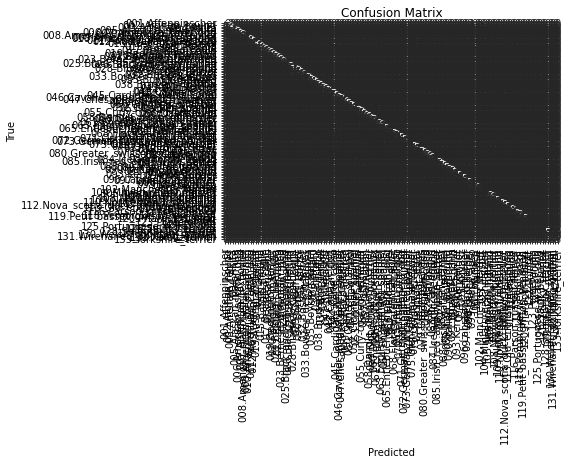

In [ ]:
c = np.argmax(predictions, axis=1)
print(c)


conf_matrix = confusion_matrix(curr_gen.classes, c)

print("Confusion Matrix:")
print(conf_matrix)

true_labels = curr_gen.labels

cr = classification_report(true_labels, c, output_dict=True)

print("\nClassification Report:")
print(classification_report(true_labels, c))

class_names = list(curr_gen.class_indices.keys())

df = pd.DataFrame({
    'Label': [class_names[i] for i in range(curr_gen.num_classes)],
    'Precision': [cr[str(i)]['precision'] for i in range(curr_gen.num_classes)],
})

df.to_csv('classification_metrics_133class.csv', index=False)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=curr_gen.class_indices.keys(),
            yticklabels=curr_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

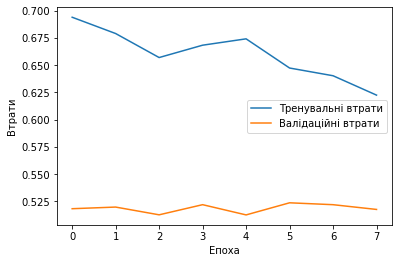

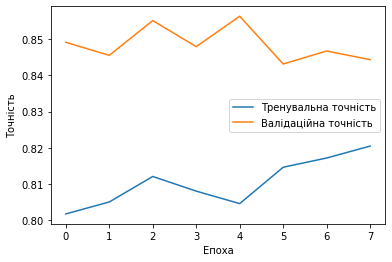

In [ ]:
plt.plot(model_result.history['loss'], label='Тренувальні втрати')
plt.plot(model_result.history['val_loss'], label='Валідаційні втрати')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.show()

plt.plot(model_result.history['accuracy'], label='Тренувальна точність')
plt.plot(model_result.history['val_accuracy'], label='Валідаційна точність')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.show()